In [1]:
%reload_kedro

2023-02-16 15:53:31,389 - kedro.extras.extensions.ipython - INFO - No path argument was provided. Using: /Users/guilhermepalazzo/Desktop/dev/git_repositories/crypto_msc_thesis
2023-02-16 15:53:31,677 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2023-02-16 15:53:31,840 - kedro.extras.extensions.ipython - INFO - ** Kedro project crypto_thesis
2023-02-16 15:53:31,841 - kedro.extras.extensions.ipython - INFO - Defined global variable `context`, `session`, `catalog` and `pipelines`


In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import plot_importance

In [4]:
plt.style.use('fivethirtyeight')

In [44]:
y_train = catalog.load("xgboost_target_train")
y_test = catalog.load("xgboost_target_test")
y_pred = catalog.load("xgboost_model_predict")
model = catalog.load("xgboost_fitted_model")

2023-02-16 16:16:10,139 - kedro.io.data_catalog - INFO - Loading data from `xgboost_target_train` (ParquetDataSet)...
2023-02-16 16:16:10,163 - kedro.io.data_catalog - INFO - Loading data from `xgboost_target_test` (ParquetDataSet)...
2023-02-16 16:16:10,183 - kedro.io.data_catalog - INFO - Loading data from `xgboost_model_predict` (ParquetDataSet)...
2023-02-16 16:16:10,195 - kedro.io.data_catalog - INFO - Loading data from `xgboost_fitted_model` (PickleDataSet)...


In [16]:
y_train = y_train.rename(columns={"label": "train_data"})
y_test = y_test.rename(columns={"label": "test_data"})

y_all = y_train.merge(y_test, left_index=True, right_index=True, how="outer")

<AxesSubplot: title={'center': 'Timeseries sensical eval'}, xlabel='window_nbr'>

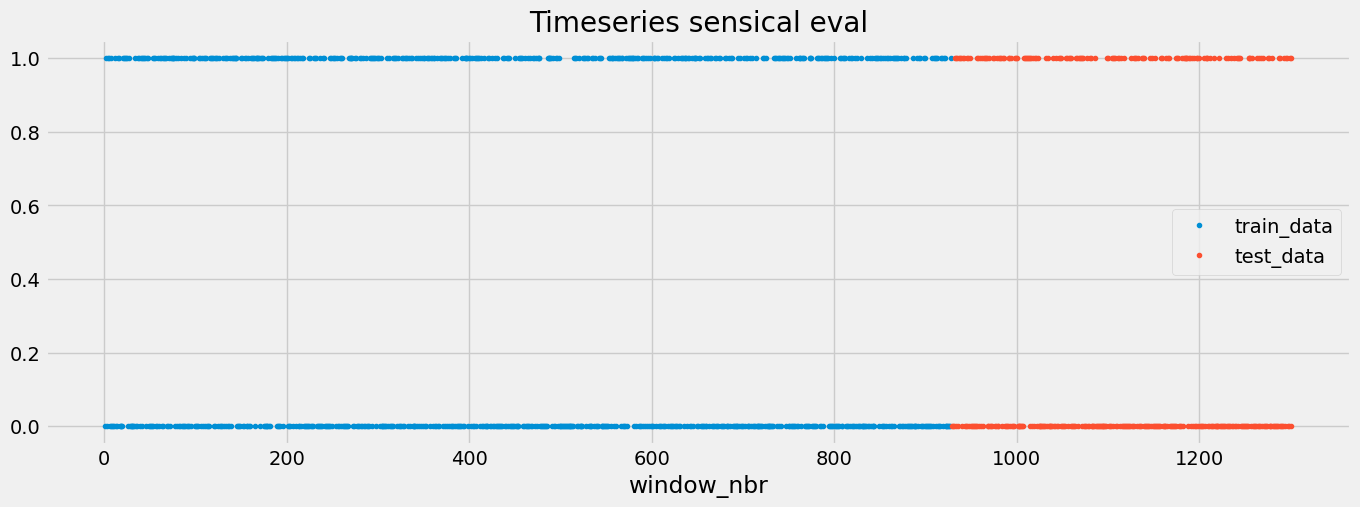

In [18]:
# evaluate if there's no data leakage between train and test sets
y_all.plot(figsize=(15,5), title="Timeseries sensical eval", style=".")

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

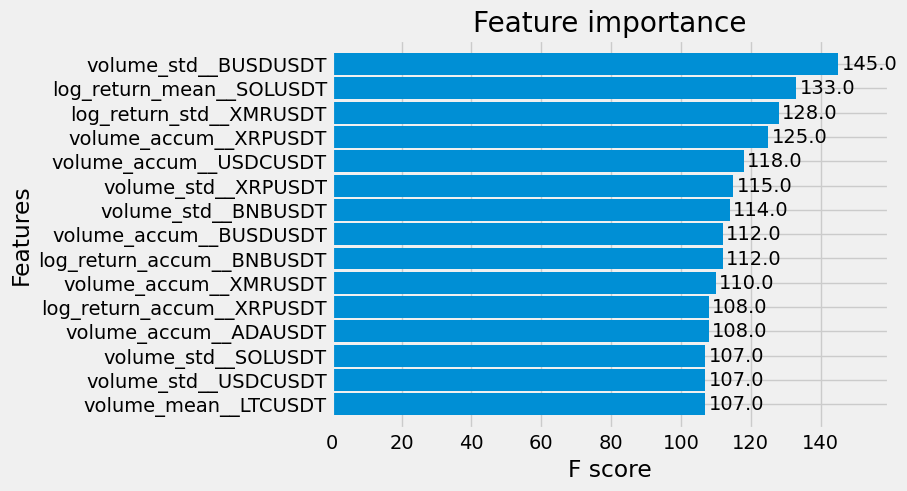

In [57]:
# get features' importance
plot_importance(model, height=0.9, max_num_features=15)

In [53]:
# find out the points where there's wrong predictions through time
# the biggest the overlap, the better
y_test_pred = y_test.rename(columns={"label": "y_true"}) \
                .merge(y_pred, left_index=True, right_index=True, how="inner")
assert y_test_pred.shape[0] == y_test.shape[0] == y_pred.shape[0]

<AxesSubplot: xlabel='window_nbr'>

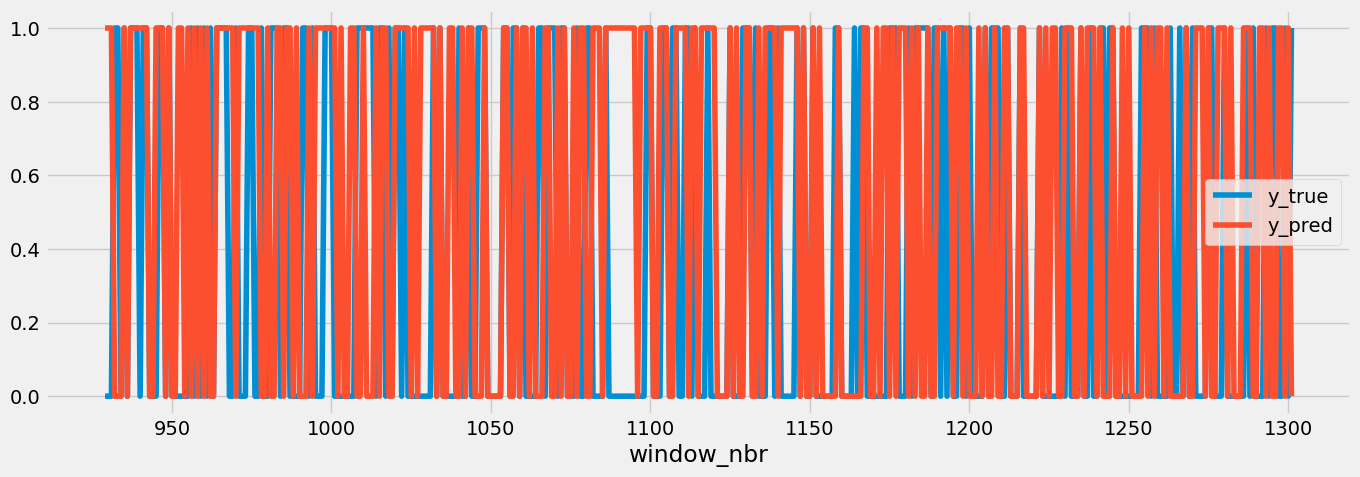

In [56]:
y_test_pred.plot(figsize=(15, 5))